In [ ]:
from torchvision import transforms as tfms
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
import torch
import numpy

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"


# load model

In [ ]:
from utils.model_loader import load_model

config_path = './configs/v1-inference.yaml'
ckpt_path = '../stable-diffusion-webui/models/Stable-diffusion/pastelMixStylizedAnime_pastelMixFull.safetensors'

model = load_model(config_path, ckpt_path)

# Create Sampler

In [16]:
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from modules.sampler import VanillaStableDiffusionSampler

sampler = VanillaStableDiffusionSampler(PLMSSampler, model)


# Text-to-Image 

In [17]:
from modules.prompt_parser import get_learned_conditioning, get_multicond_learned_conditioning

model.to(torch_device)
# prompt = ["A cool digital illustration of a steampunk computer laboratory with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors"]
# prompt_negative = [""]
prompt = ["masterpiece, best quality, loli, animal ears, blue eyes, seduction, sea, wet,  cute face, long hair, white hair, 1girl, sexy,  8K, high resolution"]
prompt_negative = ["deformation, ugly, bad quality, distortion"]

height = 512
width = 512
random_seed = 626633957

num_inference_steps = 40
cfg_scale = 7.5
batch_size = 1

# Positive Text Embedding
positive_text_embeddings  = get_multicond_learned_conditioning(model, prompt, num_inference_steps)
# positive_text_embeddings = model.get_learned_conditioning(prompt)
print(f'the shape of postive text embedding: {positive_text_embeddings}')

# Negative Text Embedding
negative_text_embeddings = get_learned_conditioning(model, prompt_negative, num_inference_steps)
# negative_text_embeddings  = model.get_learned_conditioning(prompt_negative)
print(f'the shape of negative text embedding: {negative_text_embeddings}')

# Prep latents
torch.manual_seed(random_seed)
latents = torch.randn((batch_size, 4, height // 8, width // 8), device='cpu')
latents = latents.to(torch_device)


sample_ddim = sampler.sample(steps=num_inference_steps, 
                             conditioning=positive_text_embeddings, 
                             unconditional_conditioning=negative_text_embeddings, 
                             unconditional_guidance_scale=cfg_scale, 
                             x=latents)

the shape of postive text embedding: <modules.prompt_parser.MulticondLearnedConditioning object at 0x7fd01f64e830>
the shape of negative text embedding: [[ScheduledPromptConditioning(end_at_step=40, cond=tensor([[-0.3775,  0.0151, -0.0611,  ..., -0.5000, -0.2917,  0.0669],
        [ 0.6019,  0.0330,  1.2110,  ..., -1.9056, -0.0695,  0.6040],
        [ 0.2015, -0.0911,  1.7371,  ..., -0.7249,  0.5819, -0.9623],
        ...,
        [-0.7843, -0.7737,  0.9856,  ..., -1.3240,  1.0810, -0.0233],
        [-0.7867, -0.7550,  0.9745,  ..., -1.3066,  1.0592, -0.0392],
        [-0.7648, -0.7647,  1.0222,  ..., -1.3194,  1.1355, -0.1126]],
       device='cuda:0'))]]
Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 40 timesteps


PLMS Sampler: 100%|██████████| 40/40 [00:06<00:00,  6.51it/s]


In [12]:
print(sample_ddim.shape)

torch.Size([1, 4, 64, 64])


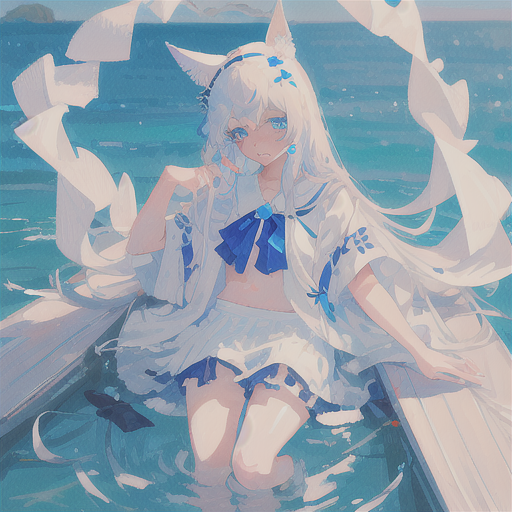

In [18]:

image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]